# Tutorial 3: Volatility Models

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import sys
import os
from statsmodels.tsa.stattools import acf, pacf, ccf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, t, ecdf
import arch
from statsmodels.stats.diagnostic import acorr_ljungbox

## 0. Functions 

### 0.1 ACF/PACF

In [5]:
from statsmodels.tsa.tsatools import lagmat2ds

def partial_correlation(X: np.ndarray, i, j):
    r"""
    Given Precision Matrix P from data X, PartialCorr(X_i, X_j | X \ {X_i, X_j})
    = (-1) * P[i,j] / np.sqrt(P[i, i] * P[j, j])
    """
    cov_mat = np.cov(X, rowvar=False)
    prec_mat = np.linalg.inv(cov_mat)
    partial_corr = - prec_mat[i, j] / np.sqrt(prec_mat[i, i]) / np.sqrt(prec_mat[j, j])
    return partial_corr


def calc_acf(y: pd.Series, x=None, nlags=10):
    """
    :param x: if not provided, it will be y itself (autocorrelation)
    :return: Corr(X_{t}, Y_{t+i})
    """

    if x is None:
        x = y
        lag_grids = range(1, nlags + 1)
    else:
        lag_grids = range(-nlags, nlags + 1)
                
    acf = pd.Series({i: x.shift(i).corr(y) for i in lag_grids})
    acf = acf.rename_axis("i")
    return acf


def calc_pacf(y: pd.Series, x=None, nlags=10):
    """
    Copmute Time Series Partial Correlation:
    1. If only y is provided: 
    (a). Corr(Y_{t}, Y_{t+i}) for i = 1
    (b). Corr(Y_{t}, Y_{t+i} | Y_{t+1} to Y_{t+i-1}) for i >= 2
    
    2. If x & y are provided: 
    (a). Corr(X_{t}, Y_{t+i}) for i = 0.
    (b). Corr(X_{t}, Y_{t+i} | Y_{t}) for i = 1.
    (c). Corr(X_{t}, Y_{t+i} | X_{t+1} to X_{t+i-1} & Y_{t} to Y_{t+i-1}) for i >= 2.
    (d). Swap (X_{t}, Y_{t}) for i < 0
    """
    pacf = {}
    
    if x is None:
        data = y
        lag_grids = range(1, nlags + 1)
    else:
        data = pd.concat([y, x], axis=1).dropna()
        lag_grids = range(-nlags, nlags + 1)
        pacf[0] = y.corr(x)

    for l in lag_grids:
        if l == 0:
            continue
        if l < 0:
            data2 = data.loc[:, ::-1]
        else:
            data2 = data
            
        data_lag = lagmat2ds(data2, np.abs(l), trim="both", dropex=1)
        pacf[l] = partial_correlation(data_lag, 0, -1)
        
    pacf = pd.Series(pacf).rename_axis("i").sort_index()
    return pacf


def plot_ts_corr(y: pd.Series, x=None, nlags=10, xname=None, yname=None,
                 figsize=(12, 6), title=None, ax=None, subplots=False, **kwargs):
    acf = calc_acf(y, x, nlags)
    pacf = calc_pacf(y, x, nlags)

    if title is None:
        title = "Time Series Correlations"
    if xname is not None:
        title += f", $X_t$: {xname}"
    if yname is not None:
        title += f", $Y_t$: {yname}"
    
    X_Y = "Y" if x is None else "X" 
    acf_name = f"Corr(${X_Y}" + "_{t}, Y_{t+i}$)"
    pacf_name = f"PartialCorr(${X_Y}" + "_{t}, Y_{t+i}$)"
    
    if subplots:
        fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True, **kwargs)
        acf.plot.bar(ax=ax[0], title=acf_name)
        pacf.plot.bar(ax=ax[1], title=pacf_name)
        fig.suptitle(title, y=1)
        fig.tight_layout();
        plt.show();
    else:
        cf = pd.concat({acf_name: acf, pacf_name: pacf}, axis=1)
        if ax is None:
            plt.figure(figsize=figsize, **kwargs)
            ax = plt.gca()
        cf.plot.bar(ax=ax)
        ax.set_title(title)

### 0.2 GARCH Resid Plots

In [7]:
def plot_against_theo(x, theo_dist, theo_dist_kwargs={},
                      title='QQ Plot', norm=True, ax=None, **kwargs):
    empirical_cdf = ecdf(x).cdf
    e_q, e_prob = empirical_cdf.quantiles, empirical_cdf.probabilities
    theo_q = theo_dist.ppf(e_prob, **theo_dist_kwargs)

    if ax is None:
        plt.figure(**kwargs)
        ax = plt.gca()

    ax.set_title(title)
    ax.scatter(theo_q, e_q, s=5)
    ax.set_xlabel('theoretical')
    ax.set_ylabel('empirical')
    ax.plot(theo_q, theo_q, linestyle='--', color='r')

def resid_plot(res: arch.univariate.base.ARCHModelResult, figsize=(12, 12), title=None):
    if title is None:
        title = f"Residual Diagnostics for {res.model.y.name}"
    
    resid_unit = res.resid / res.resid.std()
    resid_norm = res.resid / res.conditional_volatility
    
    fig, ax = plt.subplots(4, 2, figsize=figsize)
    plt.suptitle(title, y=1)

    # Time Series Plots of residuals
    res.resid.plot(title="Returns", ax=ax[0, 0])
    
    res.conditional_volatility.plot(title="Conditional Volatility", ax=ax[0, 1])
    
    pd.Series(resid_norm).plot(title="Standardized Residuals", ax=ax[1, 0])
    
    pd.Series(resid_norm**2).plot(title="(Standardized Residuals) ** 2", ax=ax[1, 1])

    # Statistical Tests: QQ Plot, Autocorrelation Plots
    dist_param_names = res.model.distribution.parameter_names()
    theo_dist_kwargs = {'parameters': res.params[dist_param_names]}

    plot_against_theo(resid_unit, res.model.distribution, theo_dist_kwargs=theo_dist_kwargs,
                      ax=ax[2, 0], title="QQ Plot of Residuals")

    plot_ts_corr(resid_unit ** 2, ax=ax[2, 1], title="ACF/PACF", yname="Residuals ** 2")

    plot_against_theo(resid_norm, res.model.distribution, theo_dist_kwargs=theo_dist_kwargs,
                      ax=ax[3, 0], title="QQ Plot of Standardized Residuals")

    plot_ts_corr(resid_norm ** 2, ax=ax[3, 1], title="ACF/PACF", yname="(Standardized Residuals) ** 2")
 
    plt.tight_layout()
    plt.show()

### 0.3 GARCH from R

In [9]:
#!pip install rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

rugarch = importr('rugarch')
rmgarch = importr('rmgarch')
rbase = importr('base')
rutils = importr('utils')

def convert_to_R_df(df):
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        r_df = ro.conversion.py2rpy(df)
    return r_df

def convert_from_R_df(r_df):
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        df = ro.conversion.rpy2py(r_df)
    return df

### 0.4 Data

In [11]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

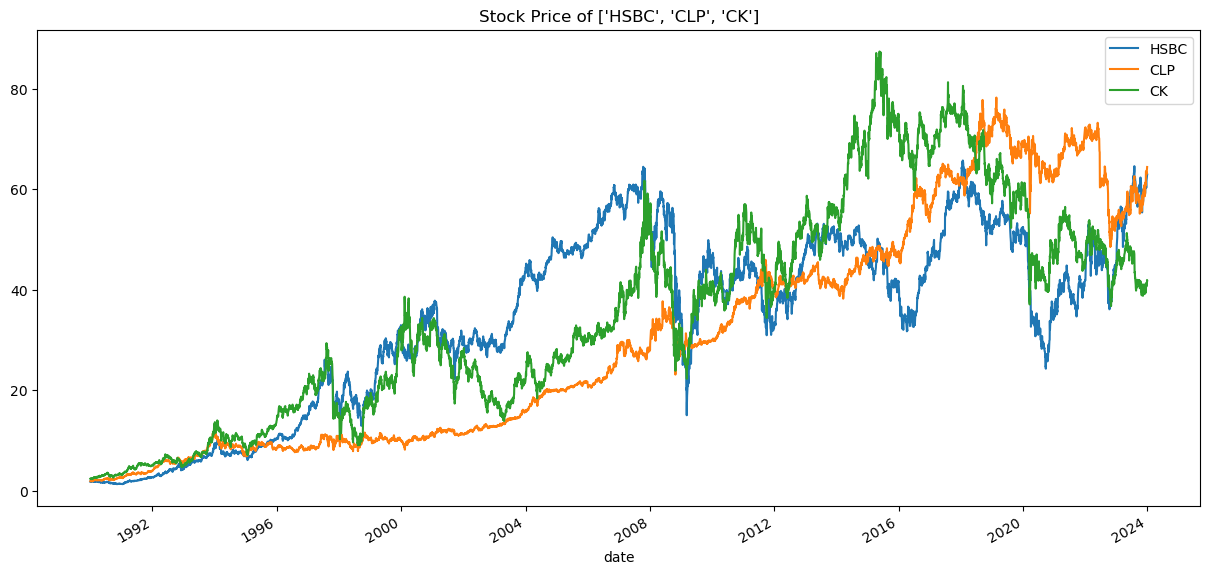

In [12]:
px = read_file('HSI/HSI_1990_2024.csv', index_col=0) # means we set column 0 as the index
px = px.rename_axis('date')
px.index = pd.to_datetime(px.index)
px.plot(figsize=(15, 7), title=f"Stock Price of {list(px.columns)}");

rets = np.log(px.ffill(limit=2)).diff()

## 1. Mean Estimation

### 1.1 Simple Moving Average

Recall the $L$-day moving average of time series $X_t$ (where $L$ stands for lookback) is

$\hat \mu_t = \frac{1}{L} \sum_{i=0}^{L-1} x_{t-i}$

This estimate carries equal weight for these $L$ terms, even though the most recent terms should have greater impacts.

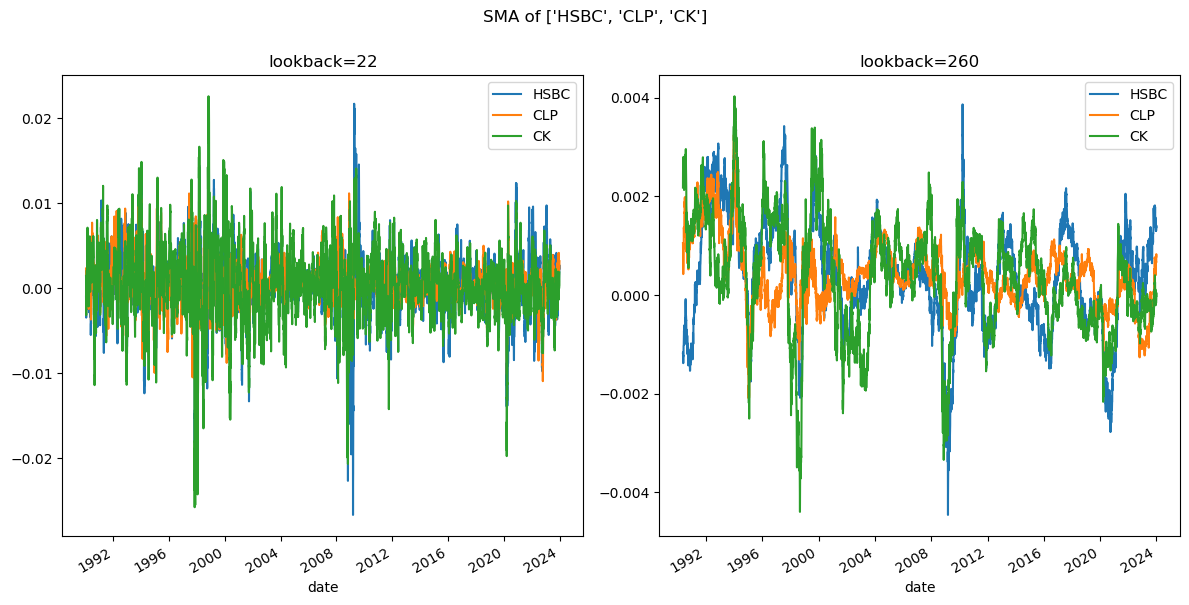

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, lookback in enumerate([22, 260]):
    sma = rets.rolling(lookback, min_periods=lookback // 3).mean() 
    sma.plot(title=f"lookback={lookback}", ax=ax[i]);

fig.suptitle(f"SMA of {list(rets.columns)}", y=1)
fig.tight_layout();
plt.show()

Homework: What does ```min_periods``` mean?

### 1.2 Exponentially Weighted Moving Average

#### 1.2.1 The Model

To overcome the eqaul-weight problem, we introduce the Exponentially Weighted Moving Average (EWMA) model, 

which gives the highest weight to the most recent term and gradually down-weights the terms as we move back in time.

$\hat \mu_t = \lambda \hat \mu_{t-1} + (1 - \lambda) x_t$, where $0 \le \lambda \le 1$

This is a **smoothing** technique. If $\lambda$ is closer to 1, then the impact of $x_t$ to $\hat \mu_t$ is smaller, so we call the model is smoother / slower.

#### 1.2.2 Recursive Formula

From below, we can see the "exponential" nature, in the sense that the impact of the $i^{th}$ lagged term is proportional to $\lambda^i$:

$\begin{align*}
\hat \mu_t &=\lambda \hat \mu_{t-1} + (1-\lambda) x_t \\
&= \lambda [ \lambda \hat \mu_{t-2}+(1-\lambda) x_{t-1}]+(1-\lambda ) x_{t} \\
& = (1-\lambda ) (x_{t}+ \lambda x_{t-1})+\lambda^2 \hat \mu_{t-2} \\
& \dots \\
& = (1-\lambda ) \ \sum_{i=0}^{m-1}\lambda^{i}x_{t-i}+\lambda^m \hat \mu_{t-m}
\end{align*}$

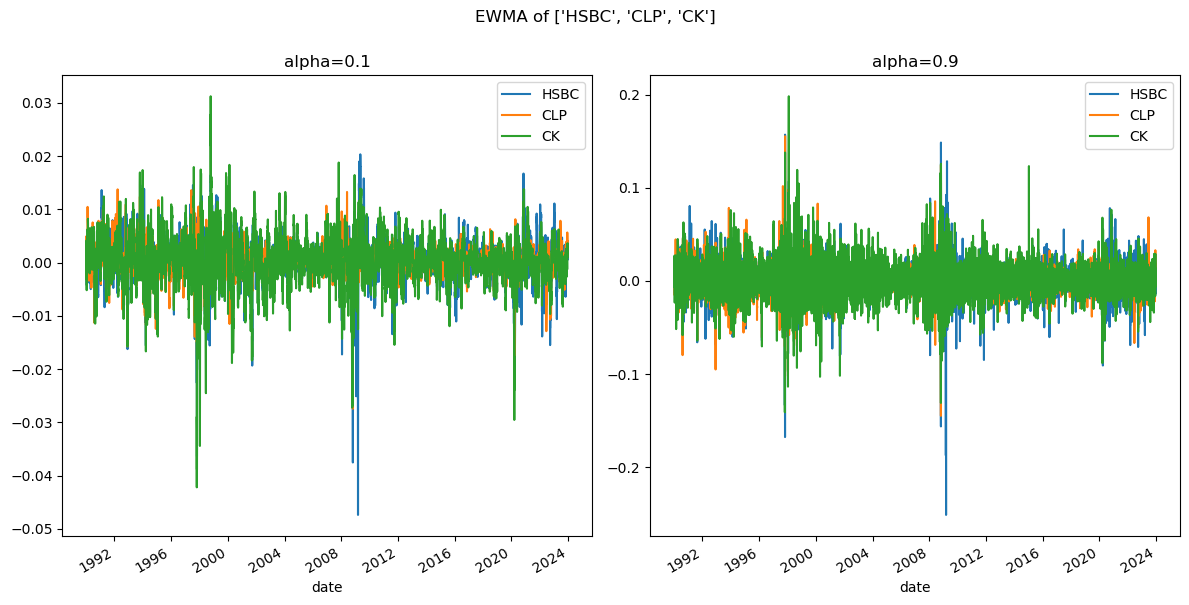

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, alpha in enumerate([0.1, 0.9]):
    ewma = rets.ewm(alpha=alpha, min_periods=5).mean() 
    ewma.plot(title=f"alpha={alpha}", ax=ax[i]);

fig.suptitle(f"EWMA of {list(rets.columns)}", y=1)
fig.tight_layout();
plt.show()

** In ```pandas.DataFrame.ewm```, they call the smoothing parameter as ```alpha``` $\alpha := 1 - \lambda$, so smaller $\alpha$ gives smoother result.

** Please **be careful** how we specfiy our model and parameters!

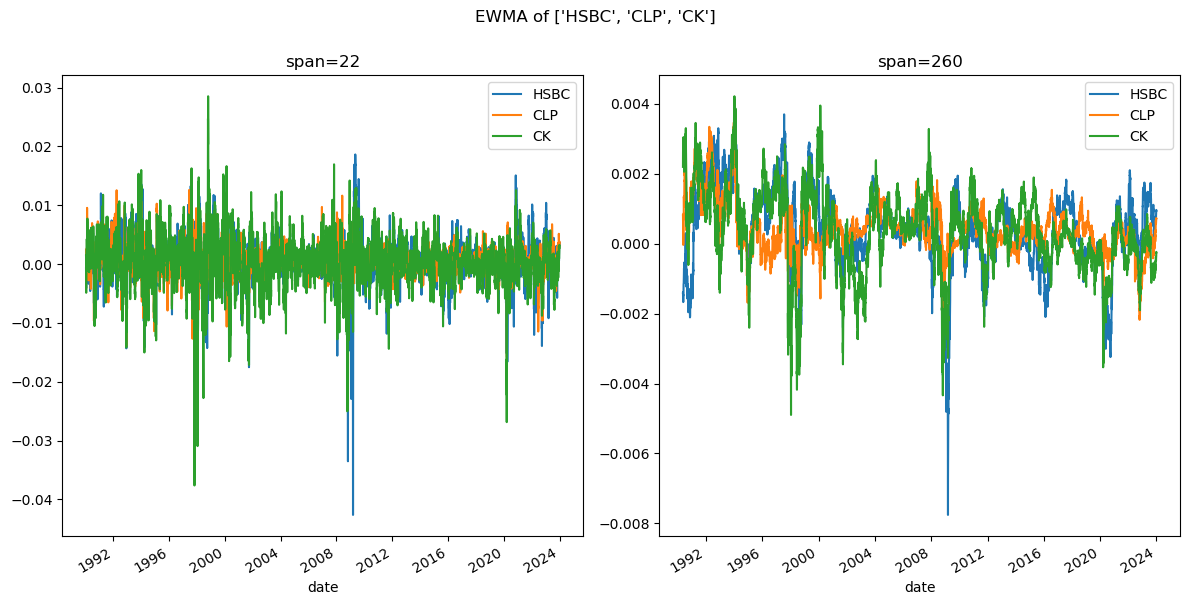

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, lookback in enumerate([22, 260]):
    ewma = rets.ewm(span=lookback, min_periods=lookback // 3).mean() 
    ewma.plot(title=f"span={lookback}", ax=ax[i]);

fig.suptitle(f"EWMA of {list(rets.columns)}", y=1)
fig.tight_layout();
plt.show()

In practice, we use ```span``` parameter more often, where $\alpha = 2 / (\text{span} + 1)$, with $\text{span} \ge 1$.

```span``` is more intuitive, as ```ewma(span=lookback)``` has a similar order of roughness as ```sma(window=lookback)```

### 1.3 ARIMA Model

ARIMA($p, d, q$) model is short for “Auto Regressive Integrated Moving Average” to model time series data. By breaking down the terms:

1. **Auto Regressive** ($p$): dependence of a present observation on some predefined number of time-lagged observations.
2. **Integrated** ($d$): differencing of the raw observations, so as to make the time-series stationary.
3. **Moving Average** ($q$): relationship between the residual errors incurred over the last few time lags and the observations.

Given times series $Y_t$, the ARIMA model can be written as the following general form:

$X_t = \alpha + \sum_{i=1}^p \beta_i X_{t-i} + \sum_{j=1}^q \phi_{j} \epsilon_{t-j} + \epsilon_{t}$

here, $X_t := (1 - B)^d Y_t$ where $B$ is the backward operator so that $B Y_t = Y_{t-1}$ for any $t$.

If $d=1$, $X_t$ is simply $Y_t - Y_{t-1}$.

ARIMA model is not the main focus of our course and today's tutorial. If interested, please take STAT4005!

## 2. Volatility Forecast

### 2.1 Simple Moving Standard Deviation

$L$-day moving variance of time series $X_t$ can similarly be defined as 

$\hat{\sigma}^2_t = \frac{1}{L - 1} \sum_{i=0}^{L-1} (X_{t-i} - \text{sma}_t) ^ 2$,

We can then compute $L$-day moving standard deviation $= \sqrt{\hat{\sigma}^2_t}$

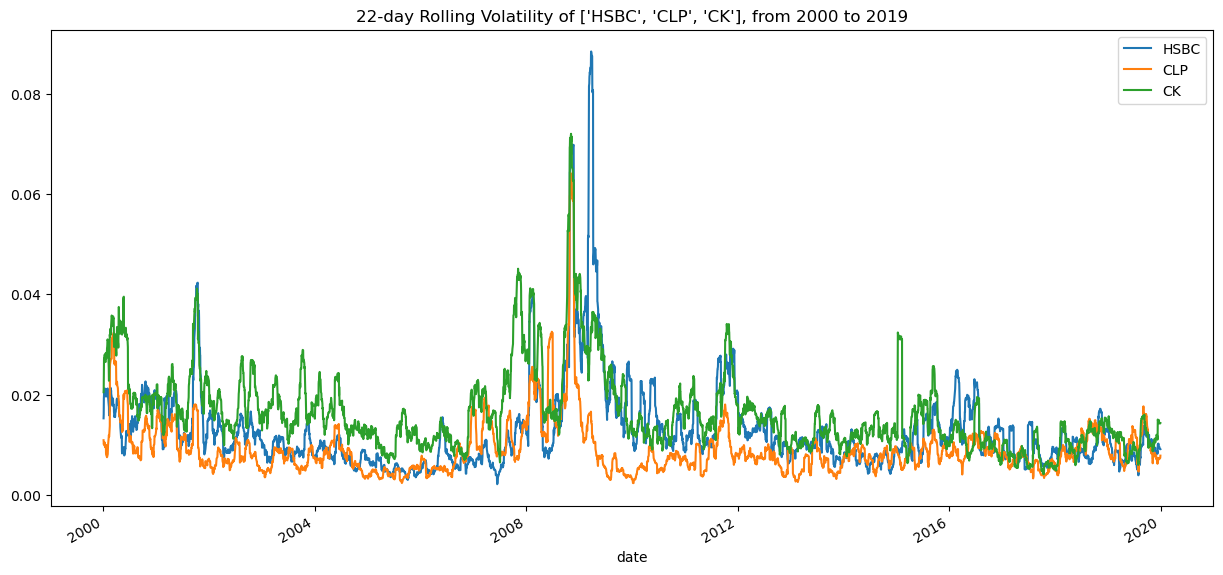

In [34]:
start, end = "2000", "2019"
lookback = 22
title=f"{lookback}-day Rolling Volatility of {list(rets.columns)}, from {start} to {end}"

vol_rolling = rets.rolling(lookback, min_periods=lookback // 3).std() 
vol_rolling.loc[start:end].plot(figsize=(15, 7), title=title);

### 2.2 Exponentially Weighted Moving Standard Deviation

Consider time series $u_t$ with mean $0$, then its EWM variance can be **forecasted** as below: (that's why we use $u_{t-1}$ instead of $u_t)$

$\hat \sigma_t^2 =\lambda \hat \sigma_{t-1}^2+(1-\lambda )u_{t-1}^2$

Similar to EWMA analysis in Section 1.2, we can derive:

$\hat \sigma_t^2 = (1-\lambda) \ \sum_{i=1}^{m}\lambda^{i-1}u_{t-i}^2+\lambda^m \hat \sigma_{t-m}^2 $

Remark: If instead of **forecasting**, we do **smoothing** with $\hat \sigma_t^2 =\lambda \hat \sigma_{t-1}^2+(1-\lambda )u_{t}^2$, 

we will get $\hat \sigma_t^2 = (1-\lambda ) \ \sum_{i=0}^{m-1}\lambda^{i}u^2_{t-i}+\lambda^m \hat \sigma^2_{t-m}$, exactly matching Section 1.2.

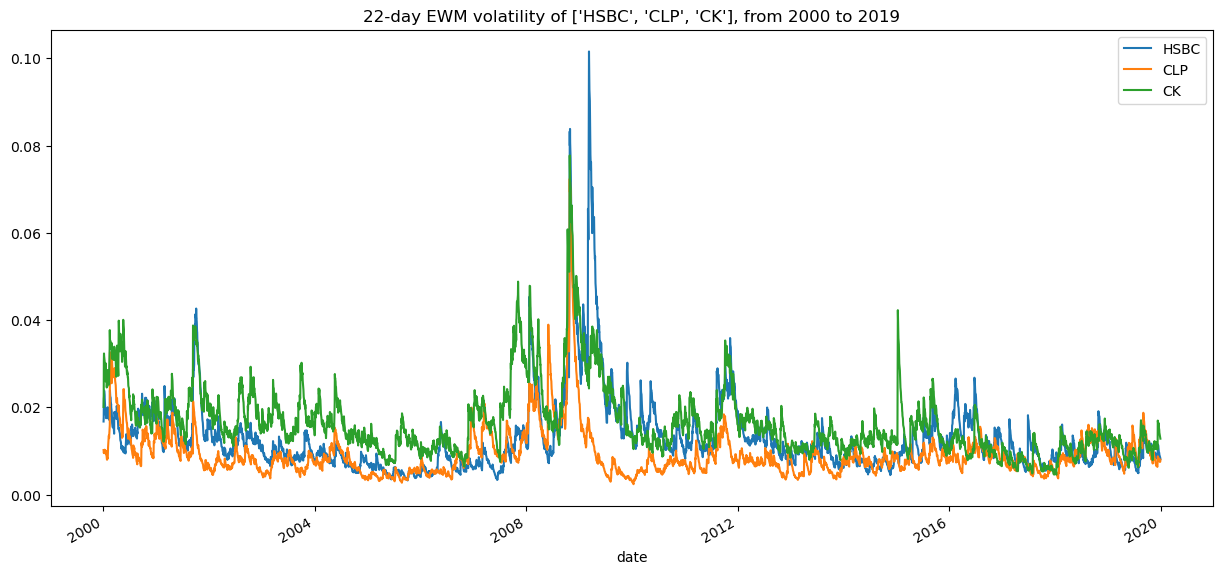

In [38]:
lookback = 22
title=f"{lookback}-day EWM volatility of {list(rets.columns)}, from {start} to {end}"

vol_ewm = rets.ewm(span=lookback, min_periods=lookback // 3).std() 
vol_ewm.loc[start:end].plot(figsize=(15, 7), title=title);

### 2.3 ARCH Model

#### 2.3.1 The Model

This model assumes that the current variance rate $\sigma_n^2$ depends on:
1. the $m$ most recent values of $u_i^2$ (autoregressive setup)
2. a long-run average variance rate $V_L$

$
\begin{equation}
	\sigma_n^2=\gamma V_L+\alpha_1 u_{n-1}^2+\ldots +\alpha_m u_{n-m}^2,
\end{equation}
$

where the coefficients are such that $\gamma+\alpha_1+ \ldots +\alpha_m=1$ (WHY?).

We further assume the following conditional independence of $u_i$'s:

$
\begin{equation}
	\frac{u_i}{\sigma_i}\bigg| u_{i-1},u_{i-2},\dots,u_1  \overset{d}{=}  \frac{u_i}{\sigma_i} \bigg| \sigma_i \sim N(0,1).
\end{equation}
$

The advantage of this model is that it introduces a **long-run variance rate**.

### 2.4 GARCH Model

#### 2.4.1 The Model

The most general GARCH model is the GARCH($p,q$) model:
\begin{equation*}
	\sigma_n^2=\gamma V_L+\alpha_1 u_{n-1}^2+\ldots + \alpha_p u_{n-p}^2+\beta_1\sigma_{n-1}^2+\ldots +\beta_q\sigma_{n-q}^2
\end{equation*}

In the EWMA model in Section 2.2, $\sigma_n^2$ is defined recursively in terms of $\sigma_{n-1}^2$ and $u_{n-1}^2$. 

In the ARCH($m$) model in Section 2.3, $\sigma_n^2$ is defined in terms of $m$ most recent values of $u_i^2$ and a long-run variance rate $V_L$. 

The GARCH model is a **hybrid** of the other two. Indeed, GARCH(1,1) model is by far the most popular one used in estimating volatility.
\begin{equation}
	\sigma_n^2=\gamma V_L+\alpha u_{n-1}^2+\beta\sigma_{n-1}^2,
\end{equation}
where $\gamma+\alpha+\beta=1$ and $V_L$ is the long-run average variance rate. Note that when $\gamma=0$, GARCH(1,1) reduces to an EWMA model. 

#### 2.4.2 Parameter Estimation

Here, we only focus on the GARCH(1,1) model. 

In general, the calibration process of the GARCH(1,1) model is by maximizing the following logarithmic likelihood function:

\begin{equation}
	l(\omega, \alpha, \beta; \mathbf u) := -\frac{1}{2} \left(N \cdot \ln (2\pi) + \sum_{n=1}^N \ln \sigma_n^2 + \sum_{n=1}^N \frac{u_n^2}{2 \sigma_n^2} \right) \
\end{equation}

In practice, we can initialize $\sigma_0^2$ with
1. the long run variance: $\sigma_0^2 := \omega / (1 - \alpha - \beta)$;
2. mean of $u^2$: $\sigma_0^2 := \omega + \alpha \cdot \overline{u^2} + \beta \cdot \overline{u^2}$;
3. the variance of $u$: $\sigma_0^2 := {\rm Var}(u)$,

where
\begin{equation*}
	\overline{u^2} := \frac{1}{N} \sum_{n=1}^N u_n^2 \, , \qquad {\rm Var}(u) := \frac{1}{N-1} \sum_{n=1}^N (u_n - \overline{u})^2 \, , \qquad \text{and} \qquad \overline{u} := \frac{1}{N} \sum_{n=1}^N u_n \, .
\end{equation*}

With different initialization of $\sigma_0^2$ and the parameters $\mathbf \theta = (\omega, \alpha, \beta)^\top$, we arrive at different MLEs. 

#### 2.4.3 Demo -- arch package

In [49]:
u = rets.HSBC.loc['2010':'2019'].fillna(0)
res_HSBC = arch.arch_model(u, mean='Zero', vol='GARCH', 
                      p=1, q=1, power=2.0, dist='normal',
                      hold_back=0, rescale=False).fit(disp='off') 

res_HSBC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   HSBC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7478.19
Distribution:                  Normal   AIC:                          -14950.4
Method:            Maximum Likelihood   BIC:                          -14933.0
                                        No. Observations:                 2463
Date:                Wed, Sep 24 2025   Df Residuals:                     2463
Time:                        13:37:33   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.0913e-06  3.773e-13  8.192e+06      0.000 [3.091e-06,3.091e-06]
alpha[1]       0.0500  7.800e-07  6.410e+04      0.000 [5.000e-02,5.000e-02]
beta[1]        0.9300  3.165e-03    293.867      0.000     [  0.924,  0.936]
============================================================================

Covariance estimator: robust
"""

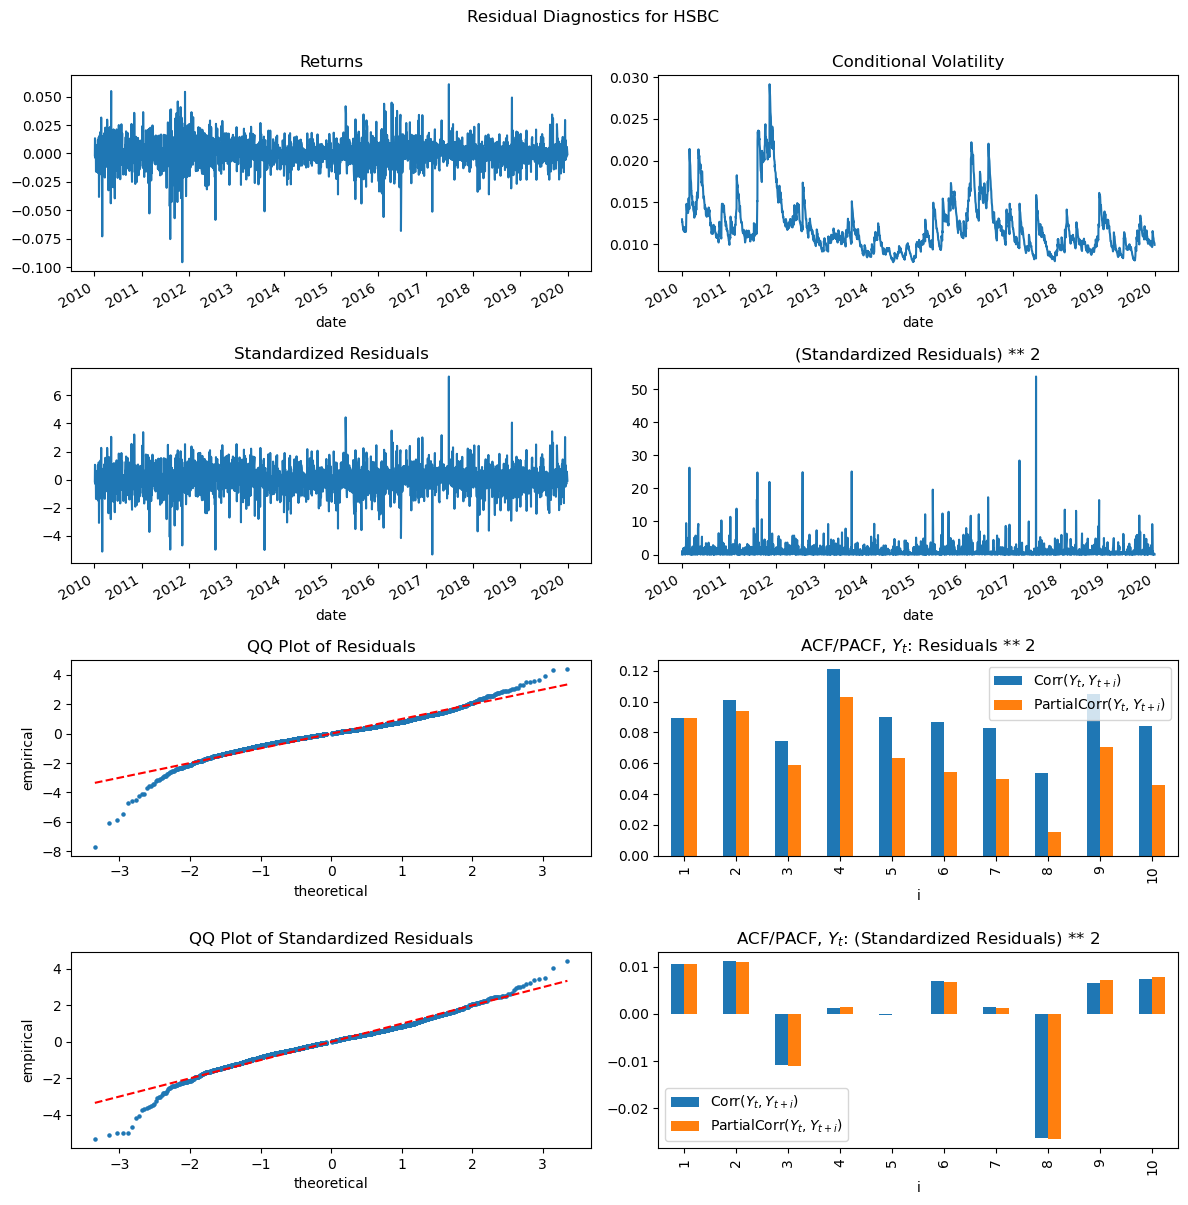

In [50]:
resid_plot(res_HSBC)

We can see that after fitting GARCH model:

1. Our normalized residuals are less fat-tailed. 
2. Autocorrelation in shock magnitude is also removed.

<u>Remarks</u>

It is noted that the parameters from ```arch_model``` are sometimes mathmatically **suboptimal**.

Interested readers please read ```Programme 7.19``` in the FDA textbook on how to accurately optimize the problem using 'L-BFGS-B' + 'SLSQP' in Python.

Alternatively, import R package ```rugarch``` here to Python.

#### 2.4.3 Forecasting Future Volatilities

Once the MLEs of $\omega$, $\alpha$, $\beta$ are obtained, we can forecast the future volatilities by using this GARCH(1,1) model. Since
\begin{align*}
	\hspace{2cm}
	\sigma_n^2 &= \omega + \alpha u_{n-1}^2 + \beta \sigma_{n-1}^2\\
	&= (1-\alpha-\beta)V_L+\alpha u_{n-1}^2 + \beta \sigma_{n-1}^2,
\end{align*}
therefore, $\sigma_n^2 - V_L = \alpha (u_{n-1}^2-V_L)+\beta(\sigma_{n-1}^2-V_L)$.

On the day $n+k$ in the future,
\begin{flalign*}
	\hspace{2cm}
	\sigma_{n+k}^2-V_L=\alpha (u_{n+k-1}^2-V_L)+\beta (\sigma_{n+k-1}^2-V_L). &&
\end{flalign*}
For GARCH(1,1) model, we can also estimate the covariances of two assets as
\begin{equation}
	\text{cov}_{n+t}=\omega+\alpha x_{n+t-1} y_{n+t-1} + \beta \text{cov}_{n+t-1} \text{ and } \rho_{n+t}=\frac{\text{cov}_{n+t}}{\sigma_{x, n+t}\sigma_{y, n+t}}
\end{equation}	

### 2.5 DCC-GARCH (Multivariate)

#### 2.5.1 The Model

Let $r_{it}$ and $\sigma_{it}$ denote the return and volatility of security $i$ at time $t$, respectively.

And $\mathbf{r}_t = (r_{1t}, r_{2t}, \dots, r_{kt})^\top$ denote the return vector. 

In DCC-GARCH(1,1) model, the variance $\sigma^2_{it}$ for each security $i$ can be modeled by an independent GARCH(1,1) process. 

The evolutionary covariance matrix at time $t$, denoted by $\mathbf{Q}_t$, is modeled recursively as:


\begin{equation}
\mathbf{Q}_t = (1 - \theta_1 - \theta_2) \mathbf{\bar{Q}} + \theta_1 \mathbf{r}_t \mathbf{r}_t^\top + \theta_2 \mathbf{Q}_{t-1} , \quad \text{for } t = n, n+1, \dots
\end{equation}	

#### 2.5.2 Alternative -- Estimating Correlation Matrix of Standardized Residuals

Alternatively, one may consider letting $\mathbf{\epsilon}_t = (\epsilon_{1t}, \epsilon_{2t}, \dots, \epsilon_{kt})^\top$ denote the marginally standardized innovation vector (for example through GARCH), 

where $\epsilon_{it} = r_{it} / \sigma_{it}$, and replace $\mathbf{r}_t$ in equation Section 2.5.1 by $\mathbf{\epsilon}_t$.

$\mathbf{\bar{Q}}$ is the unconditional covariance matrix of $\mathbf{r}_t$ and the undetermined coefficients $\theta_1, \theta_2 > 0$ are jointly constrained by $\theta_1 + \theta_2 < 1$.

Then by standardizing the evolutionary covariance matrix $\mathbf{\Sigma}_t$, the evolutionary correlation matrix at time $t$, denoted by $\mathbf{R}_t$, is given by:
\begin{equation}
\mathbf{R}_t = \text{diag}(\mathbf{Q}_t)^{-1/2} \mathbf{Q}_t \text{diag}(\mathbf{Q}_t)^{-1/2}
\end{equation}

where $\text{diag}(\mathbf{A})$ returns the diagonal matrix of the matrix $\mathbf{A}$. 

Therefore, with $\mathbf{D}_t := \text{diag}(\sigma_{1t}, \dots, \sigma_{kt})$ such that $\mathbf{\eta}_t = \mathbf{D}_t^{-1} \mathbf{u}_t$, the covariance matrix $\mathbf{H}_t = \mathbf{D}_t \mathbf{R}_t \mathbf{D}_t$.


#### 2.5.3 Demo -- Importing rmgarch from R

In [62]:
# Convert DataFrame to R format
data = rets.loc['2000':'2019'].fillna(0)
data = convert_to_R_df(data)
secs = list(data.colnames)

# Defining GARCH Model Specifications
garch_mean_model = ro.r.list(armaOrder=ro.r.c(0, 0), include_mean=False) 
garch_var_model = ro.r.list(model='sGARCH', garchOrder=ro.r.c(1,1)) 

garch_spec = rugarch.ugarchspec(mean_model=garch_mean_model,
                               variance_model=garch_var_model,
                               distribution_model='norm')

dcc_mult_spec = rugarch.multispec(rbase.replicate(garch_spec, n=len(secs)))

dcc_spec = rmgarch.dccspec(uspec=dcc_mult_spec, dccOrder=ro.r.c(1, 1),
                          distribution='mvnorm', model='DCC')

# Fitting GARCH model to Data
dcc_GARCH = rmgarch.dccfit(spec=dcc_spec, data=data)

In [63]:
dcc_GARCH_fitted = dcc_GARCH.do_slot('mfit')
dcc_GARCH_coef = dcc_GARCH_fitted.rx2('coef')
print(dcc_GARCH_coef)

    [HSBC].mu  [HSBC].omega [HSBC].alpha1  [HSBC].beta1      [CLP].mu 
 3.000142e-04  1.143190e-06  6.778633e-02  9.292028e-01  3.376645e-04 
  [CLP].omega  [CLP].alpha1   [CLP].beta1       [CK].mu    [CK].omega 
 1.317236e-06  1.121963e-01  8.807795e-01  3.108248e-04  1.957051e-06 
  [CK].alpha1    [CK].beta1  [Joint]dcca1  [Joint]dccb1 
 4.976109e-02  9.443435e-01  1.910225e-02  9.647268e-01 



In [64]:
dcc_GARCH_corr = dcc_GARCH_fitted.rx2('R')
dcc_GARCH_corr = pd.DataFrame(dcc_GARCH_corr, index=pd.to_datetime(data.rownames), 
                              columns=[(i, j) for i in secs for j in secs])
dcc_GARCH_corr

,"(HSBC, HSBC)","(HSBC, CLP)","(HSBC, CK)","(CLP, HSBC)","(CLP, CLP)","(CLP, CK)","(CK, HSBC)","(CK, CLP)","(CK, CK)"
2000-01-03,1.0,0.317178,0.541339,0.317178,1.0,0.354269,0.541339,0.354269,1.0
2000-01-04,1.0,0.323311,0.511279,0.323311,1.0,0.321747,0.511279,0.321747,1.0
2000-01-05,1.0,0.324280,0.535478,0.324280,1.0,0.322700,0.535478,0.322700,1.0
2000-01-06,1.0,0.344288,0.615223,0.344288,1.0,0.341837,0.615223,0.341837,1.0
2000-01-07,1.0,0.369511,0.631101,0.369511,1.0,0.373577,0.631101,0.373577,1.0
...,...,...,...,...,...,...,...,...,...
2019-12-23,1.0,0.481627,0.677907,0.481627,1.0,0.477943,0.677907,0.477943,1.0
2019-12-24,1.0,0.473218,0.675236,0.473218,1.0,0.473809,0.675236,0.473809,1.0
2019-12-27,1.0,0.470083,0.672695,0.470083,1.0,0.469458,0.672695,0.469458,1.0
2019-12-30,1.0,0.472385,0.670682,0.472385,1.0,0.466452,0.670682,0.466452,1.0


We know get the fitted Correlation Matrix $R$. We can further compute Covariance Matrix from from $DRD$.

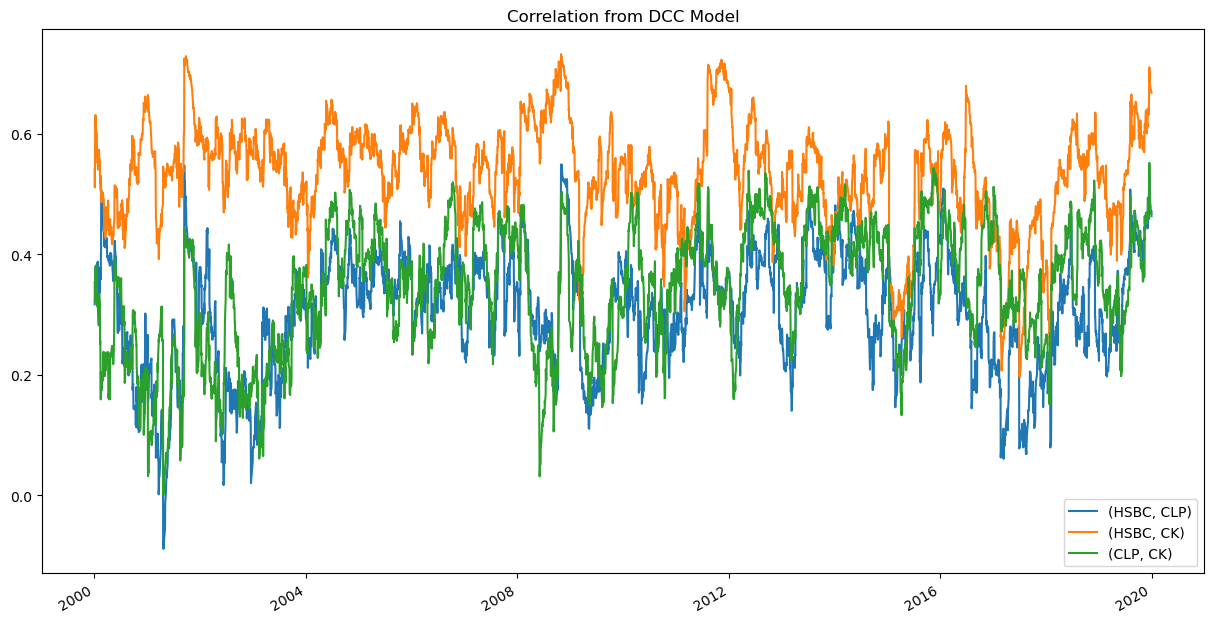

In [66]:
secs_pair = [(i, j) for i in secs for j in secs if i > j]
dcc_GARCH_corr_utri = dcc_GARCH_corr[secs_pair]
dcc_GARCH_corr_utri.plot(title="Correlation from DCC Model", figsize=(15, 8));

## 3. Autocorrelation and Cross-Correlation

### 3.1 ACF and PACF Plots

#### 3.1.1 ACF Formula

ACF is straightforward. It tells us how previous values of a time series can predict itself:

$ACF(i) = Corr(Y_t, Y_{t+i})$

It is symmetric around 0. $ACF(i) = ACF(-i)$

#### 3.1.2 PACF Formula

PACF accounts for the fact that if $Y_t$ is autocorrelated, for example:

$Y_t = \rho Y_{t-1} + \epsilon_t$

Then, even though $Y_{t-2}$ has no additional predictive power on $Y_t$, $Corr(Y_t, Y_{t-2}) = \rho^2 \neq 0$.

So, we reformulate it using partial correlation **conditional** on some control variables, as defined below:

1. $PACF(i) = Corr(Y_{t}, Y_{t+i})$ for $i = 1$
2. $PACF(i) = Corr(Y_{t}, Y_{t+i} | Y_{t+1}, \dots, Y_{t+i-1})$ for $i \ge 2$

The exact formula for partial correlation will not be covered here, interested readers please visit:
1. documentation in ```calc_pacf()```
2. ```https://en.wikipedia.org/wiki/Partial_autocorrelation_function```
3. ```Using Matrix Inverseion``` in ```https://en.wikipedia.org/wiki/Partial_correlation```

There are many ways to compute PACF, e.g. Durbin–Levinson Algorithm, but this is outside the scope of this course.

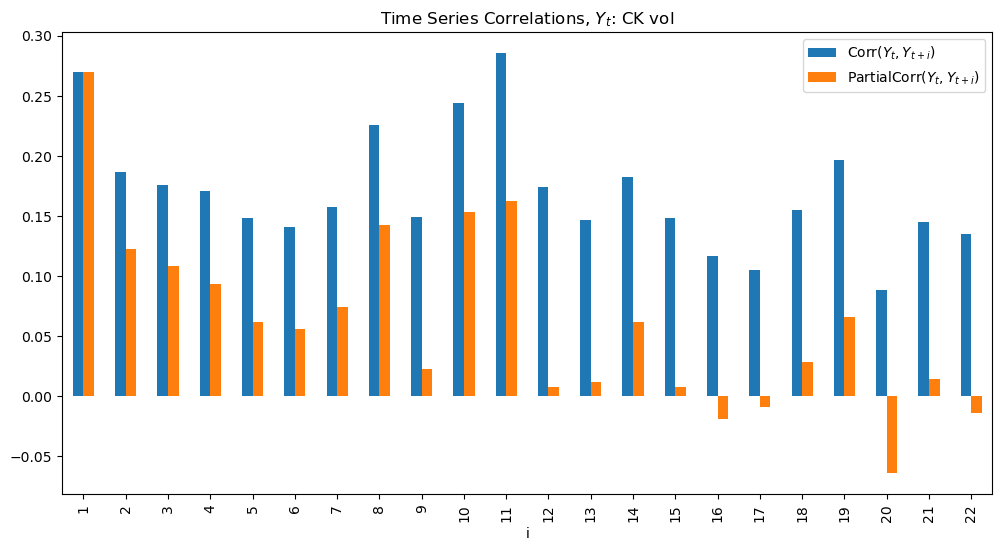

In [73]:
y = (rets.CK ** 2).loc['2000':'2019'].fillna(0)
plot_ts_corr(y, yname='CK vol', nlags=22);

In the above example, we let $Y_t$ be the volatility of CK.

As we can see, $Y_t$ has a strong autocorrelation and partial autocorrelation of $~20\%$ and $~10\%$ respectively.

#### 3.1.3 Cross Correlations

We can extend the concept of ACF and PACF given an exogenous variable $X_t$ (HSBC vol in our case)


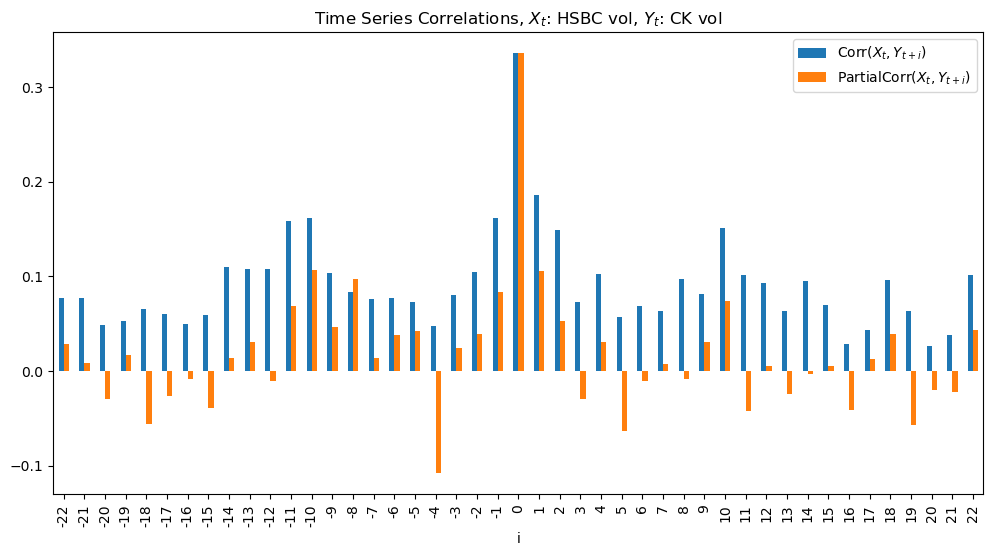

In [77]:
x = (rets.HSBC ** 2).loc['2000':'2019'].fillna(0)
plot_ts_corr(y, x, yname='CK vol', xname='HSBC vol', nlags=22);

Now we see:
1. $X_t, Y_t$ are ~$30 \%$ correlated contemperaneously.
2. Cross Correlation of $X_t, Y_{t + i}$ is ~15% for $i \neq 0$
3. Accounting for control variables, $X_{t-1}, X_{t-2}$ has ~$5 - 10\%$ partial correlations / predictive power with $Y_t$, but is almost $0$ after lag $2$.
4. $Y_{t-1}, Y_{t-2}, Y_{t-3}$ each has ~$5\%$ partial correlations with $X_t$, and even some small predictive power up to $Y_{t-10}$.

### 3.2 Ljung-Box Test

The Ljung-Box test is a statistical test used to assess the **presence of autocorrelation** in the residuals of a time series data set. 

It is commonly employed to evaluate the goodness-of-fit of a time series model. 

The test is based on the Ljung-Box statistic $Q$, which measures the overall autocorrelation of the residuals.

#### 3.2.1 Test Statistics

The formula for the Ljung-Box statistic is given by:

$
Q = n(n+2)\sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{n - k}
$

where $n$ is the number of observations, $h$ is the maximum lag considered, and $\hat{\rho}_k$ represents the sample autocorrelation at lag $k$.

#### 3.2.3 Critical Value

If $Q > \chi^2_{1-\alpha, h}$, then at level $\alpha$, it indicates significant autocorrelation in the residuals, and a lack of fit of the model. 

#### 3.2.4 Demo -- Back to our Fitted GARCH Model in 2.4.3

In [86]:
ret_sq_HSBC = res_HSBC.resid ** 2
resid_sq_HSBC = (res_HSBC.resid / res_HSBC.conditional_volatility) ** 2

compare_acorr = pd.concat({'raw': acorr_ljungbox(ret_sq_HSBC, lags=10),
                           'GARCH': acorr_ljungbox(resid_sq_HSBC, lags=10)}, 
                          names=['y', 'stats'], axis=1)

compare_acorr = compare_acorr.rename_axis('lag')
compare_acorr

y             raw                   GARCH          
stats     lb_stat     lb_pvalue   lb_stat lb_pvalue
lag                                                
1       19.760061  8.779829e-06  0.274153  0.600559
2       44.850594  1.823128e-10  0.583186  0.747072
3       58.454010  1.257384e-12  0.868453  0.833033
4       94.575847  1.402666e-19  0.872620  0.928456
5      114.572434  4.422546e-23  0.872781  0.972161
6      133.038047  2.944915e-26  0.991337  0.985939
7      149.933996  4.191546e-29  0.996551  0.994884
8      157.104833  6.443702e-30  2.706856  0.951387
9      184.243838  6.579876e-35  2.812950  0.971251
10     201.802696  6.789909e-38  2.946611  0.982653

We can see that the raw resid squared has p-value $< 0.05$ at all lags, indicating autocorrelations.

After fitting GARCH model, the normalized residual squared has p-value $>0.05$ at all lags, so we don't reject that it is serially independent.

### 3.3 Granger Causality (Optional but Useful for Project)

Sometimes, it can be easy to improve spurious causation in financial markets.

For example, in HFT, we can imagine prices are mean-reverting, 
while in certain slow-adapting markets, prices are predicted by trends. 

#### 3.3.1 Motivating Example

Consider the following model:

$\begin{align*}
Y_t & = 0.5 Y_{t-1} + \epsilon_t \\
Y_t & = 0.8 X_t + \eta_t
\end{align*}$

If we simply run $Corr(X_{t-1}, Y_{t}) = Corr(X_{t-1}, 0.5 (0.8 X_t + \eta_t) + \epsilon_t)$, we can be tempted to claim $X_{t-1}$ can predict $Y_t$ as it has $40 \%$ correlation.

But in fact, it is just because $X_t, Y_t$ are contemperaneously correlated, and that $Y_t$ has momentum. $X_{t-1}$ is actually not a useful indicator.

#### 3.3.2 Hypothesis Testing

Therefore, we introduce the concept of **control variables** to time series modelling:

We claim that $X_t$ **Granger-causes** $Y_t$ at lag $q$, if knowing $X_{t-1:t-q}$ significantly improves our estimate for $Y_t$ compared with the AR$(p)$ model:

$\begin{align*}
H_0 &: y_t = \alpha + \sum_{i=1}^p a_i y_{t-i} + \epsilon_t \\
\text{v.s.} & \\
H_1 &: y_t = \alpha + \sum_{i=1}^p a_i y_{t-i} + \sum_{j=1}^q b_j x_{t-j} + \epsilon_t \\
\end{align*}$.

This can be tested using ANOVA techniques, e.g. F-statistics.

In [94]:
def format_test_result(res):
    res2 = pd.DataFrame({k: v[0]['ssr_ftest'] for k, v in res.items()},
                        index=['F_stat', 'pvalue', 'df_denom', 'df_num'])
    res2 = res2.T.rename_axis('lag')
    return res2

In [95]:
x_cause_y = grangercausalitytests(pd.concat([y, x], axis=1), maxlag=10, verbose=False)
format_test_result(x_cause_y)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,F_stat,pvalue,df_denom,df_num
lag,,,,
1,55.424117,1.140211e-13,4927.0,1.0
2,30.422578,7.389370e-14,4924.0,2.0
3,20.162970,5.524216e-13,4921.0,3.0
4,16.614150,1.564919e-13,4918.0,4.0
5,17.427170,3.831018e-17,4915.0,5.0
6,14.987476,4.554090e-17,4912.0,6.0
7,12.697042,2.995236e-16,4909.0,7.0
8,11.227461,7.209398e-16,4906.0,8.0
9,10.462422,3.478983e-16,4903.0,9.0


There is a built in ```statsmodels.tsa.stattools.grangercausalitytests()```, where you specify the parameter ```max_lag```

Then it run hypothesis testing $H_0$ (with $p$ = ```max_lag```) vs $H_1$ (with $p$ = $q$ = ```max_lag```)

You can see that the causality is significant for all lags = 1 to 10.



#### 3.3.3 Modifying Granger Causality

However, sometimes we are more interested in the "single" effect of $X_{t-q}$ instead of the "joint" effect of $X_{t-1:t-q}$,

and we should therefore modify our testing as follows:

$\begin{align*}
H_0 &: y_t = \alpha + \sum_{i=1}^p a_i y_{t-i} + \sum_{j=1}^{q-1} b_j x_{t-j} + \epsilon_t \\
\text{v.s.} & \\
H_1 &: y_t = \alpha + \sum_{i=1}^p a_i y_{t-i} + \sum_{j=1}^q b_j x_{t-j} + \epsilon_t \\
\end{align*}$.

And this is highly related ```calc_pacf()``` that we wrote above (where we force $p=q$).

Intuitively, if $PartialCorr(X_t, Y_{t+p})$ is significant, then we should reject $H_0$.

HW: How to modify code in ```grangercausalitytests()``` to conduct the hypothesis testing we wish above?

Feel free to check ```https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools/_stattools.html#grangercausalitytests```

HINT: the line ```dtaown = add_constant(dta[:, 1 : (mxlg + 1)], prepend=False)``` is the only thing you should change

## 4. Conclusion

This has been a long tutorial on different time series models. But I have written up some convenient functions for you:
1. TS Correlations: ```plot_ts_corr()```
2. Residual Plots: ```resid_plot()``` to assess our goodness of fit of volatility models
3. Demo on how to use the package ```rmgarch```, or other packages from R in general, in Python

Package-wise:
1. ```statsmodels.tsa.stattools```
2. ```statsmodels.stats.diagnostic.acorr_ljungbox()```
3. ```arch```